# Modelo

Lo primero que vamos a hacer es describir los modelos DEVS utilizados para poder realizar la simulación.

## Sol
Modelo atómico que actúa como generador y emite radiación con cierto ángulo. En particular, éste modelo tiene únicamente 2 puertos de salida: *radiation* y *degree*, que estan conectados a los puertos de entrada del panel solar, como será descrito a continuación.

## Motor
Modelo atómico contenido por el panel solar. Recibe un parámetro, *consumption_factor*. Su único puerto de entrada es *rotation*, y cada vez que recibe un valor por este puerto, en base al *consumption_factor*, emite por su puerto de salida la *consumed_energy*, cuyo valor es redirigido a los puertos de entrada con el mismo nombre del modelo Panel Solar --para mandar al top-- y Controlador --para actualizar la batería--.

## Celda solar
Modelo atómico contenido por el panel solar. Recibe un parámetro, *conversion_factor*. Su único puerto de entrada es *received_energy*, cuyos valores provienen del panel solar y, en base al parámetro, va a absorver una cantidad de energía y la va a emitir por su puerto de salida *obtained_energy*, cuyo destino final será el Controlador --para actualizar la batería-- y el panel solar --para mandar al top--.


In [195]:
# %load_ext autoreload
# %autoreload 2

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from util_analysis import *

Primero parseamos los datos que obtenemos del output para que sea más cómodo

In [196]:
df = fetch_sim_data('vtol')
df

Processing file vtolcons-tol-cons-10-1
Processing file vtol-tol-20
Processing file vtol-tol-40
Processing file vtolcons-tol-cons-1-10
Processing file vtol-tol-0.5
Processing file vtol-tol-1
Processing file vtolcons-tol-cons-10-15
Processing file vtolcons-tol-cons-3-15
Processing file vtol-tol-80
Processing file vtolcons-tol-cons-3-1
Processing file vtol-tol-10
Processing file vtolcons-tol-cons-10-10
Processing file vtolcons-tol-cons-8-15
Processing file vtol-tol-60
Processing file vtolcons-tol-cons-10-5
Processing file vtolcons-tol-cons-3-10
Processing file vtolcons-tol-cons-1-5
Processing file vtolcons-tol-cons-5-5
Processing file vtolcons-tol-cons-3-5
Processing file vtolcons-tol-cons-8-1
Processing file vtol-tol-5
Processing file vtol-tol-3
Processing file vtolcons-tol-cons-5-15
Processing file vtolcons-tol-cons-1-15
Processing file vtolcons-tol-cons-1-1
Processing file vtolcons-tol-cons-5-1
Processing file vtolcons-tol-cons-8-10
Processing file vtol-tol-15
Processing file vtolcons-

,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.36000,0.00000,0.00000,0.00000


Primero analizamos el comportamiento del sol

In [197]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

Radiación: <bound method NDFrame.last of 0      9.14
1      9.14
2      9.14
3      9.14
4      9.14
5      9.14
6      9.14
7      9.14
8      9.14
9      9.14
10     9.14
11     9.14
12     9.14
13     9.14
14     9.14
15     9.14
16     9.14
17     9.14
18     9.14
19     9.14
20     9.14
21     9.14
22     9.14
23     9.14
24     9.14
25     9.14
26     9.14
27     9.14
28     9.14
29     9.14
       ... 
210    9.14
211    9.14
212    9.14
213    9.14
214    9.14
215    9.14
216    9.14
217    9.14
218    9.14
219    9.14
220    9.14
221    9.14
222    9.14
223    9.14
224    9.14
225    9.14
226    9.14
227    9.14
228    9.14
229    9.14
230    9.14
231    9.14
232    9.14
233    9.14
234    9.14
235    9.14
236    9.14
237    9.14
238    9.14
239    9.14
Name: sun_radiation, Length: 7200, dtype: float64>


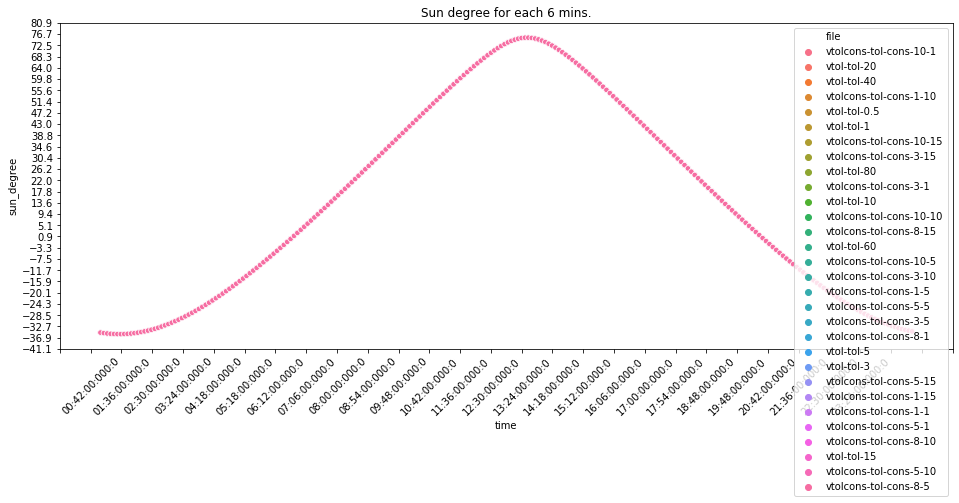

In [198]:
# plt.figure(figsize=(16, 6))
# ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
# ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.xticks(rotation=45, ha='right')
# plt.title("Sun radiation for each 6 mins.")
# plt.show()

print('Radiación: ' + str(df['sun_radiation'].last))

plt.figure(figsize=(16, 6))
ax2 = sns.scatterplot(x='time', y='sun_degree',data=df, hue='file', s=30)
ax2.xaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun degree for each 6 mins.")
plt.show()

Ahora analizamos la energía neta obtenida. Para ello, agregamos una columna con las energía neta obtenida en cada instante

In [199]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [200]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

Seleccionamos distintas tolerancias con el resto de los parámetros fijos y miramos en cada instante la energía neta obtenida en cada instante durante 1 día.

Los valores previos a las 6hs y posteriores a las 20hs fueron omitidos dado que son nulos.

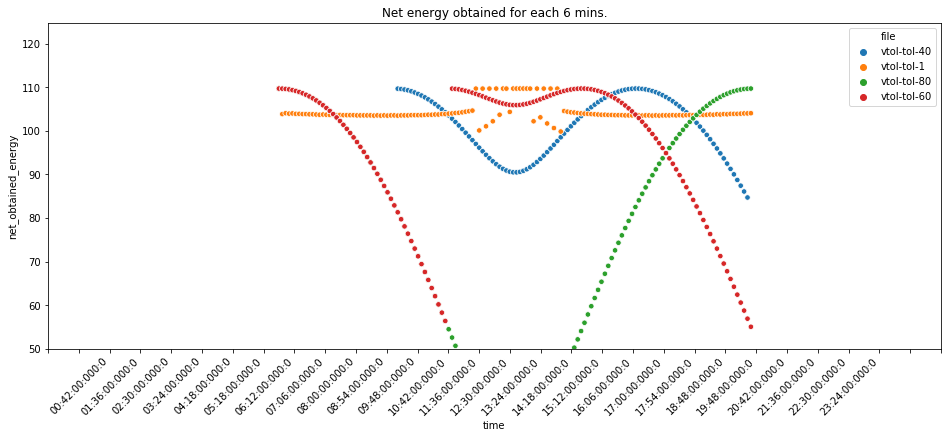

In [201]:
plt.figure(figsize=(16, 6))

selected_files = ['vtol-tol-1', 'vtol-tol-40', 'vtol-tol-60', 'vtol-tol-80']
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

Lo que puede verse  es que partiendo con una tolerancia baja, la ganancia en cada instante es menor pero se mantiene en el tiempo. Por el contrario, con las otras tolerancias se ve como empieza con una ganancia alta y va decreciendo (cuando el sol empieza a alejarse con respecto al ángulo del panel) hasta que eventualmente se supera el umbral de tolerancia efectuando el movimiento y así volviendo a obtener mucha energía. 

Nos interesa saber el rendimiento al finalizar el día, por lo cual en el próximo experimento vamos a analizar las energías capturadas por las baterías correspondientes a cada simulación, pero ahora considerando más tolerancias posibles para ver cuál conviene tomar para éste día y parámetros fijados en particular.

Tomamos entonces el último valor de la batería en cada simulación, que nos dice cuanta energía neta se acumuló en total.

In [202]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtol-tol-0.5,29215.17782
1,vtol-tol-1,29209.94719
2,vtol-tol-10,29070.66808
3,vtol-tol-15,29122.43336
4,vtol-tol-20,29128.60806
5,vtol-tol-3,29234.17320
6,vtol-tol-40,27512.20695
7,vtol-tol-5,29246.43776
8,vtol-tol-60,26158.78461
9,vtol-tol-80,21299.61605


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

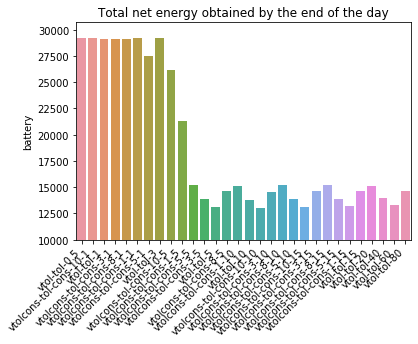

In [203]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=files_ordenados, y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=10000)
plt.title("Total net energy obtained by the end of the day")

Lo que parece indicar hasta ahora es que conviene tocar tolerancias bajas. Veamos que pasa cuando variamos distintos factores de consumo en el motor.

In [204]:
df_vtol = df
df = fetch_sim_data('vtolcons')
df

Processing file vtolcons-tol-cons-10-1
Processing file vtolcons-tol-cons-1-10
Processing file vtolcons-tol-cons-10-15
Processing file vtolcons-tol-cons-3-15
Processing file vtolcons-tol-cons-3-1
Processing file vtolcons-tol-cons-10-10
Processing file vtolcons-tol-cons-8-15
Processing file vtolcons-tol-cons-10-5
Processing file vtolcons-tol-cons-3-10
Processing file vtolcons-tol-cons-1-5
Processing file vtolcons-tol-cons-5-5
Processing file vtolcons-tol-cons-3-5
Processing file vtolcons-tol-cons-8-1
Processing file vtolcons-tol-cons-5-15
Processing file vtolcons-tol-cons-1-15
Processing file vtolcons-tol-cons-1-1
Processing file vtolcons-tol-cons-5-1
Processing file vtolcons-tol-cons-8-10
Processing file vtolcons-tol-cons-5-10
Processing file vtolcons-tol-cons-8-5


,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,vtolcons-tol-cons-10-1,9.14000,-35.36000,0.00000,0.00000,0.00000


In [205]:
print('Radiación: ' + str(df['sun_radiation'].last))

Radiación: <bound method NDFrame.last of 0      9.14000
1      9.14000
2      9.14000
3      9.14000
4      9.14000
5      9.14000
6      9.14000
7      9.14000
8      9.14000
9      9.14000
10     9.14000
11     9.14000
12     9.14000
13     9.14000
14     9.14000
15     9.14000
16     9.14000
17     9.14000
18     9.14000
19     9.14000
20     9.14000
21     9.14000
22     9.14000
23     9.14000
24     9.14000
25     9.14000
26     9.14000
27     9.14000
28     9.14000
29     9.14000
        ...   
210    9.14000
211    9.14000
212    9.14000
213    9.14000
214    9.14000
215    9.14000
216    9.14000
217    9.14000
218    9.14000
219    9.14000
220    9.14000
221    9.14000
222    9.14000
223    9.14000
224    9.14000
225    9.14000
226    9.14000
227    9.14000
228    9.14000
229    9.14000
230    9.14000
231    9.14000
232    9.14000
233    9.14000
234    9.14000
235    9.14000
236    9.14000
237    9.14000
238    9.14000
239    9.14000
Name: sun_radiation, Length: 4800, dtype: ob

In [206]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [207]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

In [208]:
# plt.figure(figsize=(16, 6))

# selected_files = ['sim-tol-1', 'sim-tol-40', 'sim-tol-60', 'sim-tol-80']
# # df2 = df[df['file'].isin(selected_files)]
# ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df, hue='file', s=30)
# ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.ylim(bottom=55)
# plt.xticks(rotation=45, ha='right')
# plt.title("Net energy obtained for each 6 mins.")
# plt.show()

In [209]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtolcons-tol-cons-1-1,15201.95709
1,vtolcons-tol-cons-1-10,13851.77700
2,vtolcons-tol-cons-1-15,13101.67694
3,vtolcons-tol-cons-1-5,14601.87705
4,vtolcons-tol-cons-10-1,15106.78624
5,vtolcons-tol-cons-10-10,13761.10624
6,vtolcons-tol-cons-10-15,13013.50623
7,vtolcons-tol-cons-10-5,14508.70623
8,vtolcons-tol-cons-3-1,15194.44372
9,vtolcons-tol-cons-3-10,13875.67373


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

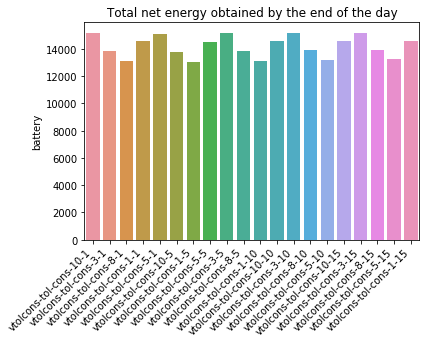

In [210]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=files_ordenados, y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.title("Total net energy obtained by the end of the day")

In [211]:
df_vtolcons = df
df = fetch_sim_data('vexttol')
df

Processing file vexttol-tol-3
Processing file vexttol-tol-6
Processing file vexttol-tol-10
Processing file vexttol-tol-1


,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,vexttol-tol-3,9.14000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,vexttol-tol-3,9.14000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,vexttol-tol-3,9.14000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,vexttol-tol-3,9.14000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,vexttol-tol-3,9.14000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,vexttol-tol-3,9.14000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,vexttol-tol-3,9.14000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,vexttol-tol-3,9.14000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,vexttol-tol-3,9.14000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,vexttol-tol-3,9.14000,-35.36000,0.00000,0.00000,0.00000


In [212]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

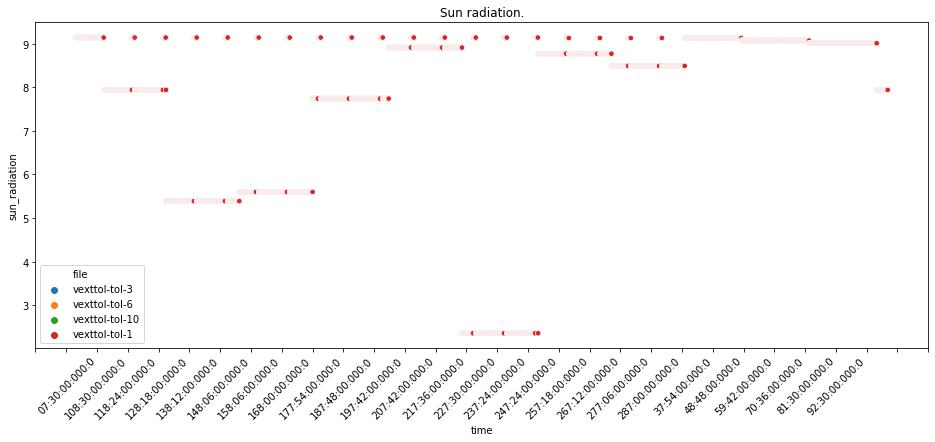

In [213]:
plt.figure(figsize=(16, 6))
ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun radiation.")
plt.show()

In [214]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

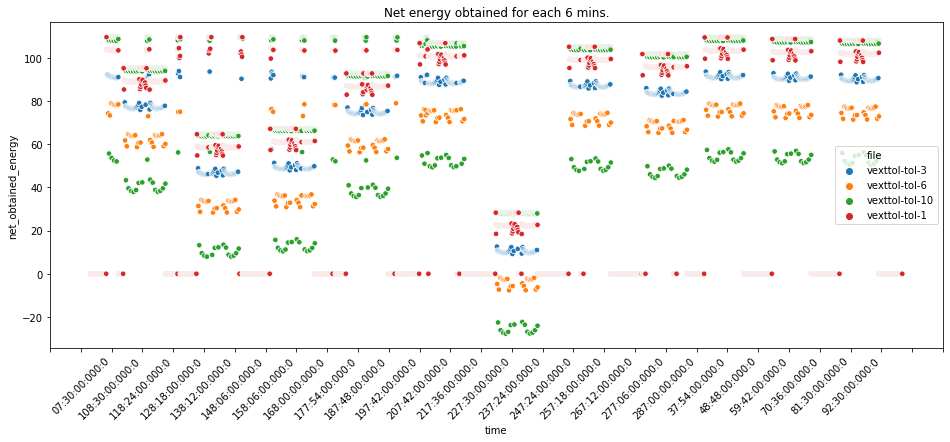

In [215]:
plt.figure(figsize=(16, 6))

ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

In [216]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vexttol-tol-1,58059.78260
1,vexttol-tol-10,57691.09100
2,vexttol-tol-3,58134.22395
3,vexttol-tol-6,58067.65111


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

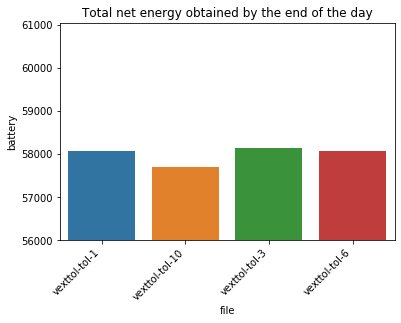

In [217]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x='file', y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=56000)
plt.title("Total net energy obtained by the end of the day")

Parece que cuanto mayor es la tolerancia, menor debe ser 